### Time Series Forecasting using LSTM

Problem Statement : Predicting temperature using weather data from Max plank Institute using univariate(Single feature as temperature) and mutlivariate(using pressure, temperature and density) as features.

Data Link :# data source: Max Plank Institute, https://www.bgc-jena.mpg.de/wetter/


In [1]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False



In [2]:
### get data from Max plank URL using tf utils

zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip' , fname='jena_climate_2009_2016.csv.zip', extract=True)
print(zip_path)

csv_path = os.path.splitext(zip_path)

print(csv_path)

13568290/13568290 [==============================] - 1s 0us/step
/root/.keras/datasets/jena_climate_2009_2016.csv.zip
('/root/.keras/datasets/jena_climate_2009_2016.csv', '.zip')


In [3]:
! ls /root/.keras/datasets/

jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip


In [4]:
### create a dataframe from downloaded csv file
import zipfile

zf = zipfile.ZipFile(zip_path)
df = pd.read_csv(zf.open('jena_climate_2009_2016.csv'))

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Observations:
1) One reading evrry 10 mins (from datatime column time diff for every record )
2) 1day = 6*24 = 144 readings
Task : Forecasting Temperature(in degree ) in future




In [5]:
## using univariate feature(Only temperature for given time)

uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

<Axes: xlabel='Date Time'>

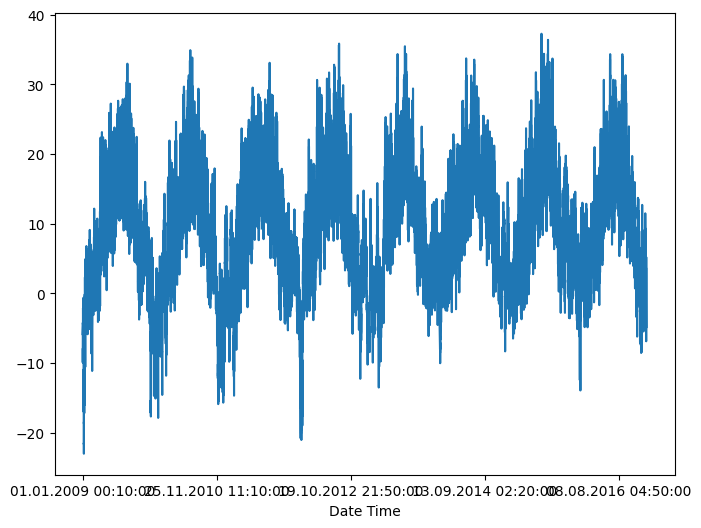

In [6]:
uni_data.plot()

In [7]:
uni_data = uni_data.values

In [8]:
## train test split for simple time series moving window average
train_split = 300000
tf.random.set_seed(13)

### standardize data
uni_data_mean = uni_data[:train_split].mean()
uni_data_std = uni_data[:train_split].std()
uni_data  = (uni_data - uni_data_mean)/ uni_data_std

print(type(uni_data))


<class 'numpy.ndarray'>


Moving Window Average


1.   Given last 20 values of observations(temp) , predict next observation
2.   MWA: predict== AVG(last 20 values)




In [9]:
## utility functions

## funtion to create data for univariate forecasting

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 20   ## last 20 values
uni_data_future = 0     ## future data

x_train_uni , y_train_uni = univariate_data(uni_data , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(uni_data , train_split , None ,uni_data_history , uni_data_future)

In [10]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)

(299980, 20, 1) (299980,)
(120531, 20, 1) (120531,)


In [11]:
print('Single window of history data' , x_train_uni[0])

print('Target Temperature to predict ' , y_train_uni[0])


Single window of history data [[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]
Target Temperature to predict  -2.1041848598100876


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

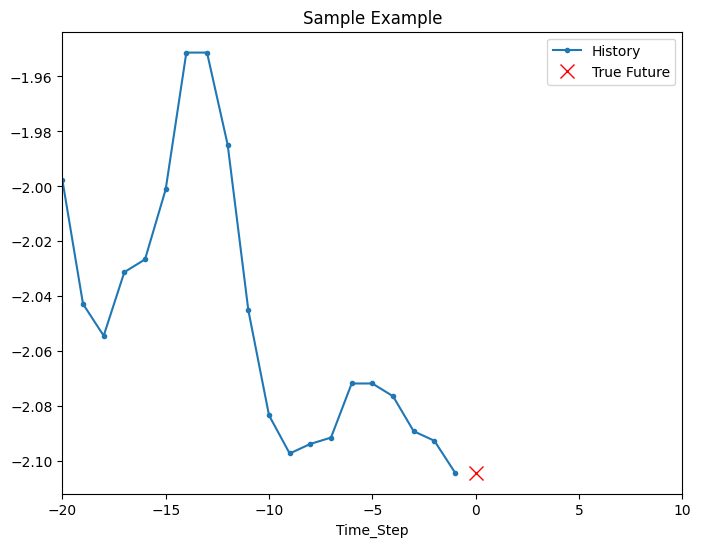

In [12]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

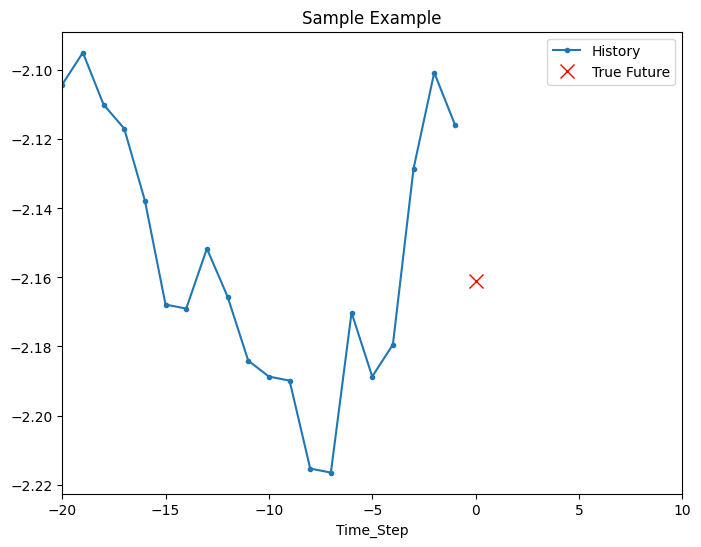

In [13]:
i = 20
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [14]:
### Moving window average

def MWA(history):
  return np.mean(history)




<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

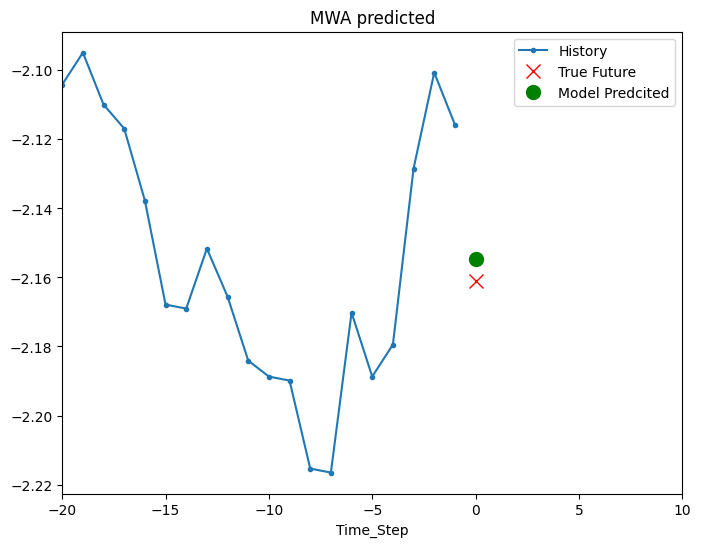

In [15]:
i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')

Univariate time-series forecasting


*   Only single feature as temperature(historical data)
*   Task:  Given last 20 observations(history) , predict next temperature value



In [16]:
## prepare tensorflow dataset
batch_size = 256
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


### Contribution: Building transformer model instead of LSTM.

In [ ]:
import tensorflow as tf

# Defining the  Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model): # init method
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model) # positional encoding

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model
        )

        sines = tf.math.sin(angle_rads[:, 0::2]) # value of sines
        cosines = tf.math.cos(angle_rads[:, 1::2]) # value of cosines

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32) # getting the positional encoding

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :] # forward pass for encoding

# Transformer Block for the model
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs) # defining the multi head attention layer
    x = tf.keras.layers.Dropout(dropout)(x) # dropout layer
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x) # layer normalization layer
    res = x + inputs # residual connection

    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res) # conv1D layers
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + res)

# This code block builds the Transformer Model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=input_shape, dtype=tf.float32) # input layer
    x = PositionalEncoding(input_shape[0], input_shape[1])(inputs) # positional encoding
    for _ in range(num_transformer_blocks): # output through n number of transformer blocks
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x) # global pooling
    for dim in mlp_units: # dense layers
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(1)(x) # final output layer
    return tf.keras.Model(inputs, outputs)


In [17]:

# Defining the  model Parameters for training the forecasting problem
input_shape = x_train_uni.shape[-2:]
head_size = 256
num_heads = 4
ff_dim = 256
num_transformer_blocks = 4
mlp_units = [128]
dropout = 0.1
mlp_dropout = 0.1

# Building and compiling the Transformer Model
transformer_model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
transformer_model.compile(optimizer='adam', loss='mae') # compiling with mean absolute error and the adam optimizer


steps = 200
EPOCHS = 10

# Training the Model
transformer_model.fit(train_uni, epochs=EPOCHS, steps_per_epoch=steps, validation_data=val_uni, validation_steps=50)


Epoch 1/10
200/200 [==============================] - 26s 48ms/step - loss: 0.8456 - val_loss: 0.6344
Epoch 2/10
200/200 [==============================] - 9s 43ms/step - loss: 0.8506 - val_loss: 0.6338
Epoch 3/10
200/200 [==============================] - 9s 43ms/step - loss: 0.8076 - val_loss: 0.6344
Epoch 4/10
200/200 [==============================] - 8s 42ms/step - loss: 0.8149 - val_loss: 0.6403
Epoch 5/10
200/200 [==============================] - 9s 46ms/step - loss: 0.8414 - val_loss: 0.6371
Epoch 6/10
200/200 [==============================] - 9s 44ms/step - loss: 0.7704 - val_loss: 0.6454
Epoch 7/10
200/200 [==============================] - 8s 43ms/step - loss: 0.8464 - val_loss: 0.6410
Epoch 8/10
200/200 [==============================] - 8s 42ms/step - loss: 0.8516 - val_loss: 0.6345
Epoch 9/10
200/200 [==============================] - 8s 42ms/step - loss: 0.7991 - val_loss: 0.6360
Epoch 10/10
200/200 [==============================] - 8s 41ms/step - loss: 0.8110 - val_l

8/8 [==============================] - 1s 5ms/step


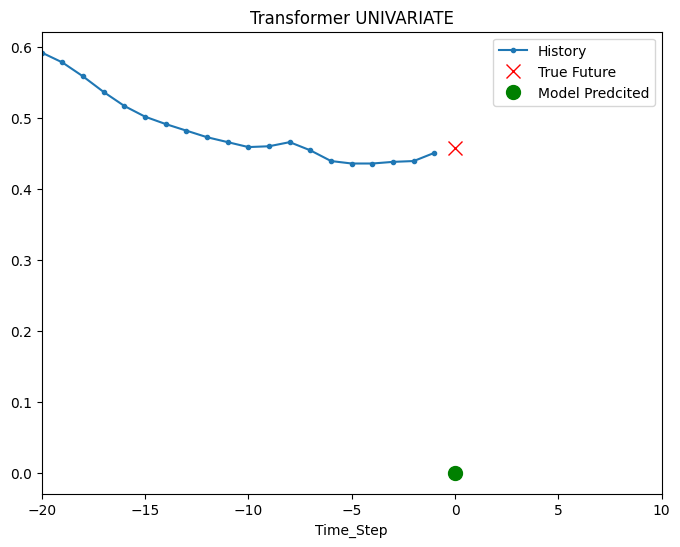

8/8 [==============================] - 0s 5ms/step


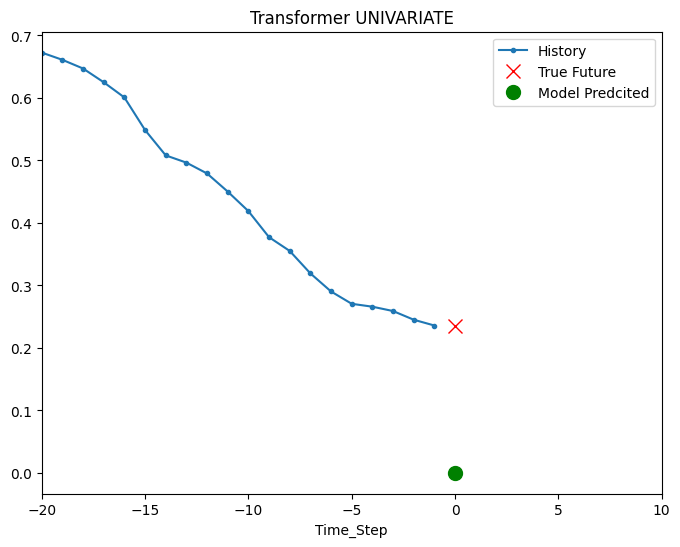

8/8 [==============================] - 0s 5ms/step


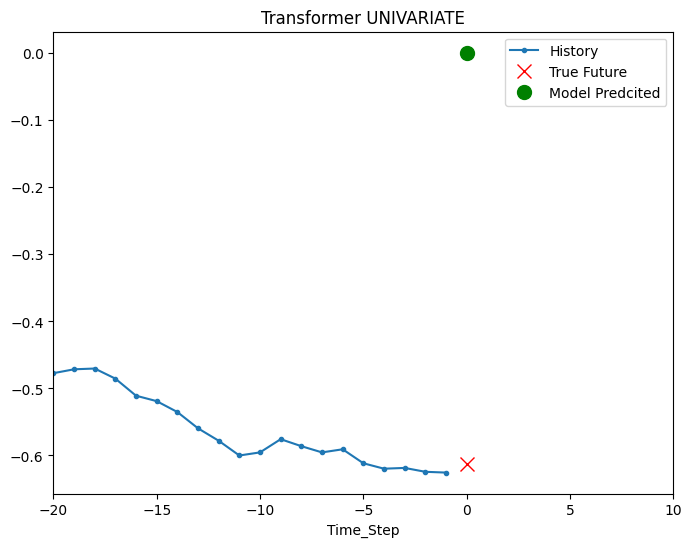

8/8 [==============================] - 0s 6ms/step


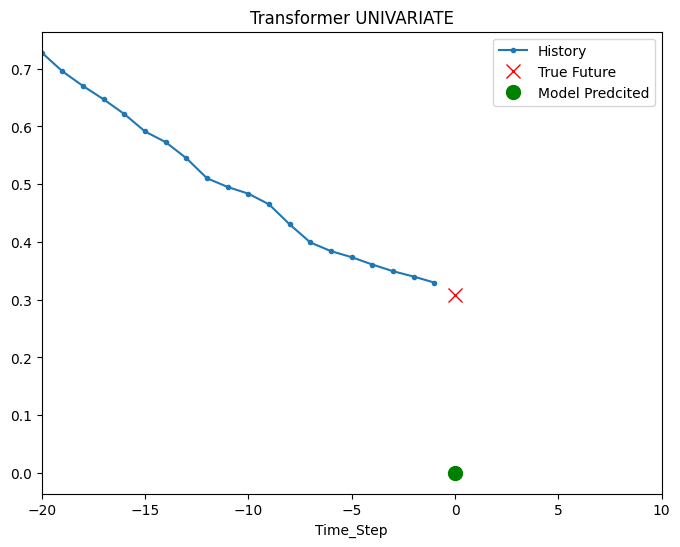

8/8 [==============================] - 0s 5ms/step


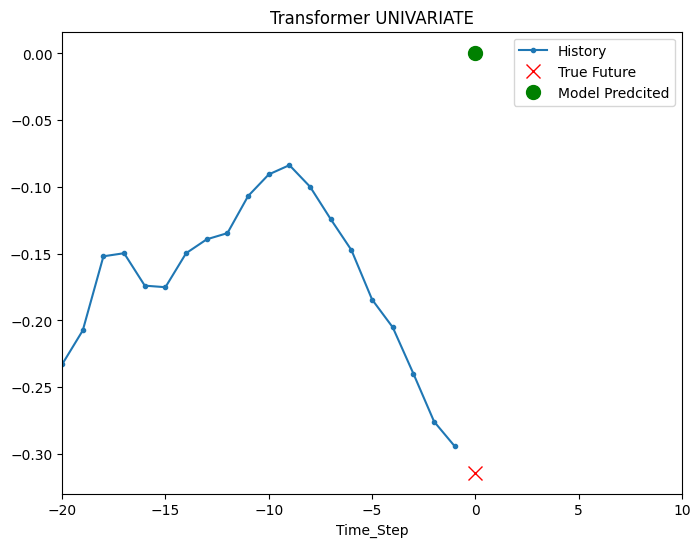

In [18]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , transformer_model.predict(i)[0]] ,0 , 'Transformer UNIVARIATE')
  plot.show()

Multivariate  and Single step Forecasting


*   Task: Given 3 features(temp , pressure , and density) at each time step can we predict the temp in future at single time step




In [19]:
## features

features_3 = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_3]
features.index = df['Date Time']
features.head()


,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

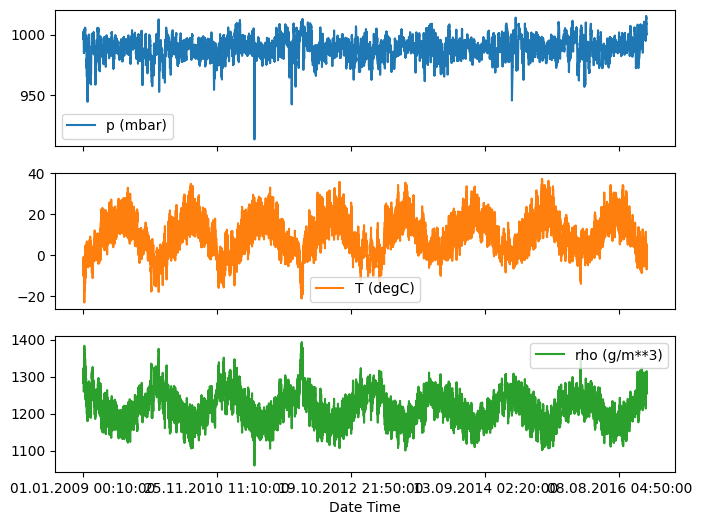

In [20]:
features.plot(subplots=True)

In [21]:
### standardize data
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std



In [22]:
### create mutlivariate data

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)



In [23]:
### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)

(299280, 120, 3) (299280,)


In [24]:
## tensorflow dataset

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)



<_RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


### Transformer model

In [ ]:
import tensorflow as tf

# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model
        )

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + res)

# Define the Transformer Model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=input_shape, dtype=tf.float32)
    x = PositionalEncoding(input_shape[0], input_shape[1])(inputs)
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

In [25]:


# Model Parameters
input_shape = x_train_ss.shape[-2:]
head_size = 256
num_heads = 4
ff_dim = 256
num_transformer_blocks = 4
mlp_units = [128]
dropout = 0.1
mlp_dropout = 0.1

# Build and Compile the Transformer Model
transformer_model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
transformer_model.compile(optimizer='adam', loss='mae')

# Print Model Summary
transformer_model.summary()

# Training Parameters
steps = 200
EPOCHS = 10

# Train the Model
transformer_model_history = transformer_model.fit(train_ss, epochs=EPOCHS, steps_per_epoch=steps, validation_data=val_ss, validation_steps=50)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 3)]             0         []                            
                                                                                                  
 positional_encoding_1 (Pos  (None, 120, 3)               0         ['input_2[0][0]']             
 itionalEncoding)                                                                                 
                                                                                                  
 multi_head_attention_4 (Mu  (None, 120, 3)               15363     ['positional_encoding_1[0][0]'
 ltiHeadAttention)                                                  , 'positional_encoding_1[0][0]
                                                                    ']                      

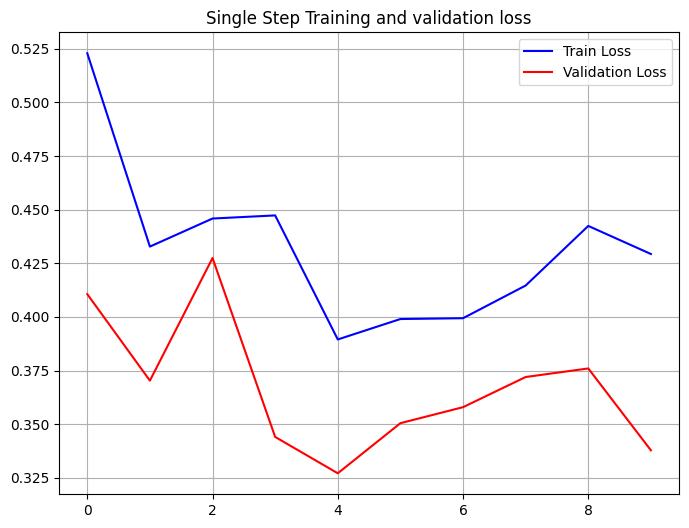

In [26]:
## plot train test loss

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(transformer_model_history , 'Single Step Training and validation loss')

8/8 [==============================] - 1s 14ms/step


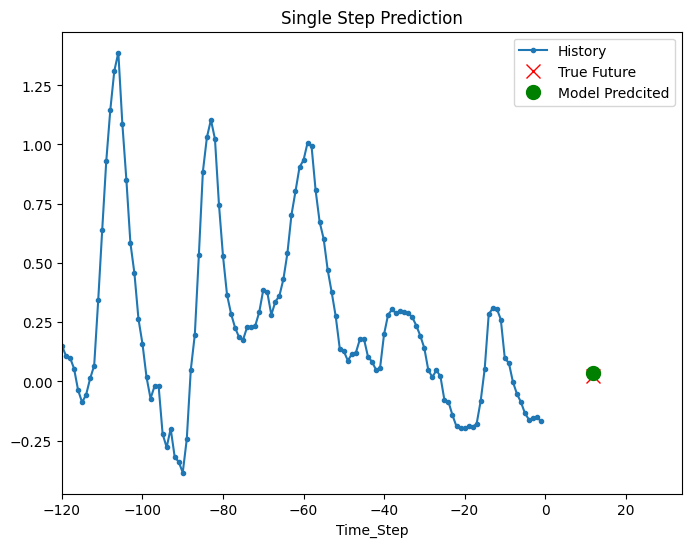

8/8 [==============================] - 0s 13ms/step


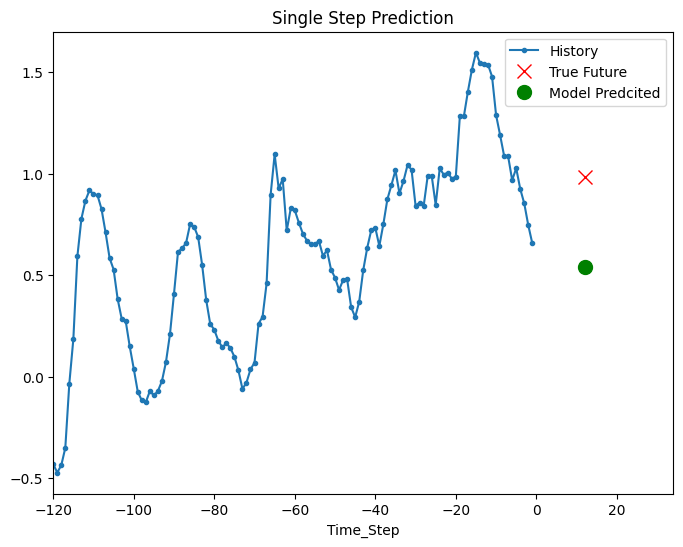

8/8 [==============================] - 0s 13ms/step


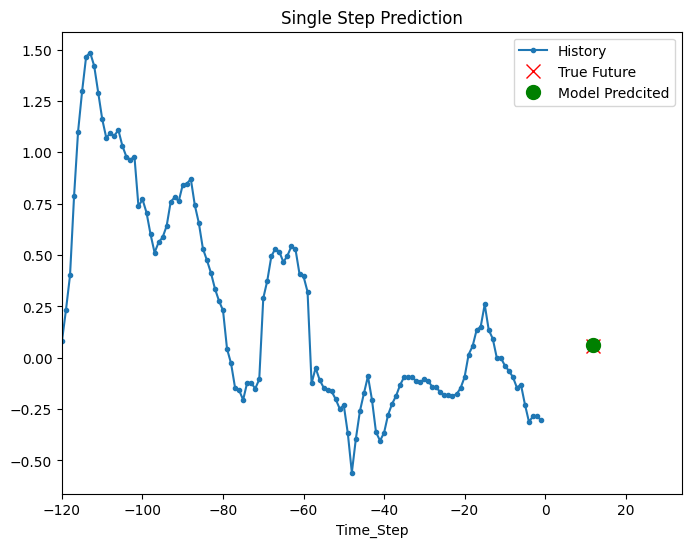

8/8 [==============================] - 0s 14ms/step


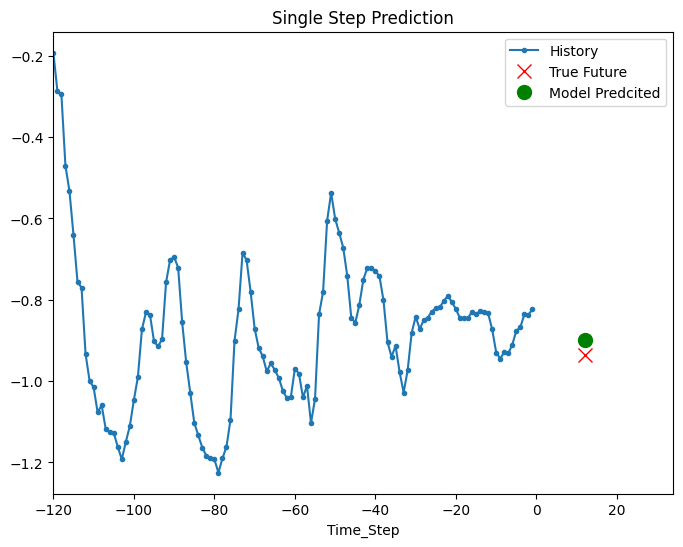

8/8 [==============================] - 0s 15ms/step


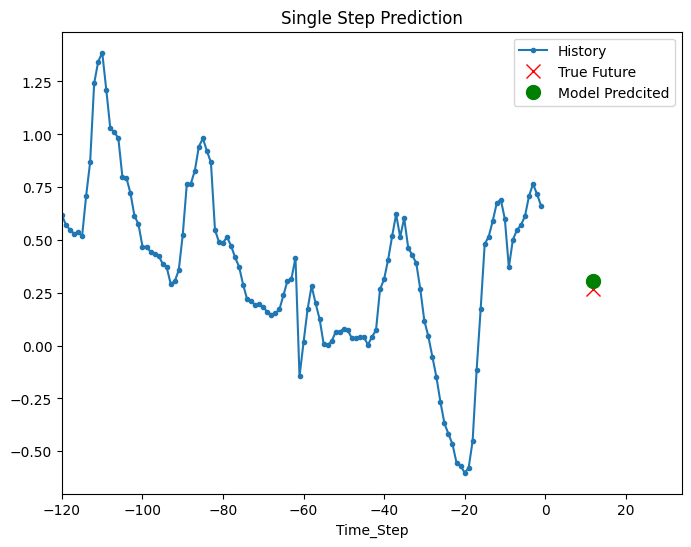

In [27]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    transformer_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Multi-variate & multi-step forecasting
-> Generate multiple future values of temperature

In [28]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(299280, 120, 3)
(299280, 72)


In [29]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

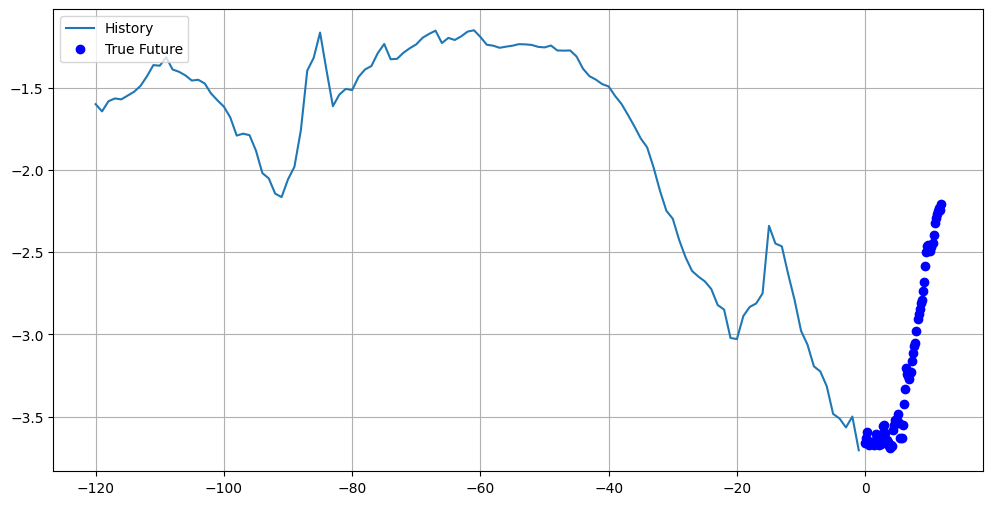

In [30]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()



for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

### Code Contribution: We use a transformer model.

In [ ]:
import tensorflow as tf # import tensorflow

# Defining the positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model): # init method
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model) # positional encoding

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates # returning the angles

    def positional_encoding(self, position, d_model): # function for positional encoding
        angle_rads = self.get_angles(
            tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model
        )

        sines = tf.math.sin(angle_rads[:, 0::2]) # sine values
        cosines = tf.math.cos(angle_rads[:, 1::2]) # cosine values

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...] # defining positional encoding

        return tf.cast(pos_encoding, tf.float32) # return the encoding
# Function for the forward pass of encoding.
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :] # the forward pass of the function

## We define the transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs) # multi-head attention layer
    x = tf.keras.layers.Dropout(dropout)(x) # dropout layer
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x) # layer normalization
    res = x + inputs # residual connection

    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res) # conv1d
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + res)

# Function that builds the Transformer Model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0, output_size=72):
    inputs = tf.keras.Input(shape=input_shape, dtype=tf.float32) # define input
    x = PositionalEncoding(input_shape[0], input_shape[1])(inputs) # getting positional encoding
    for _ in range(num_transformer_blocks): # passing through the transformer blocks
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units: # dense units
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(output_size)(x) # output unit which is multiple outputs
    return tf.keras.Model(inputs, outputs)


In [31]:

## defining the parameters of model
input_shape = x_train_multi.shape[-2:]
head_size = 256
num_heads = 4
ff_dim = 256
num_transformer_blocks = 4
mlp_units = [128]
dropout = 0.1
mlp_dropout = 0.1
output_size = 72

# Building and compiling the Transformer Model
transformer_model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout, output_size)
transformer_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

# Displaying the Model Summary
transformer_model.summary()

steps = 200
EPOCHS = 10

# Training the Model
multi_step_history = transformer_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=steps, validation_data=val_data_multi, validation_steps=50)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 120, 3)]             0         []                            
                                                                                                  
 positional_encoding_2 (Pos  (None, 120, 3)               0         ['input_3[0][0]']             
 itionalEncoding)                                                                                 
                                                                                                  
 multi_head_attention_8 (Mu  (None, 120, 3)               15363     ['positional_encoding_2[0][0]'
 ltiHeadAttention)                                                  , 'positional_encoding_2[0][0]
                                                                    ']                      

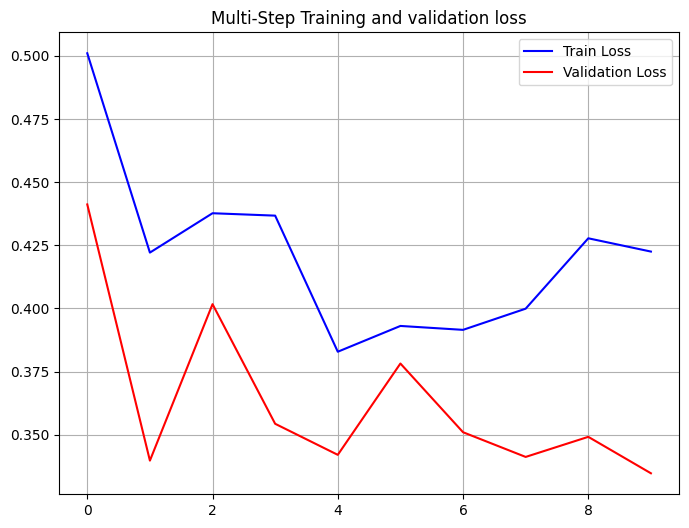

In [33]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')


8/8 [==============================] - 1s 16ms/step


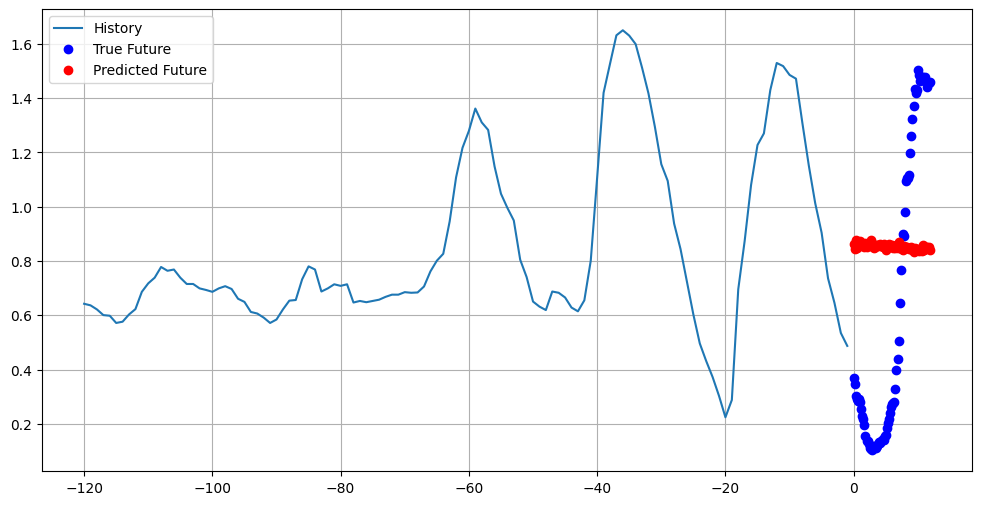

8/8 [==============================] - 0s 13ms/step


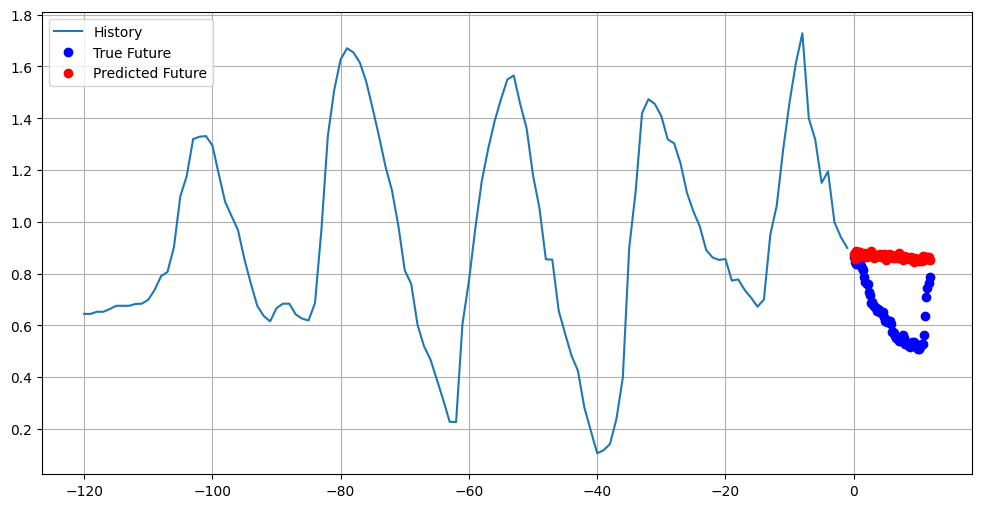

8/8 [==============================] - 0s 13ms/step


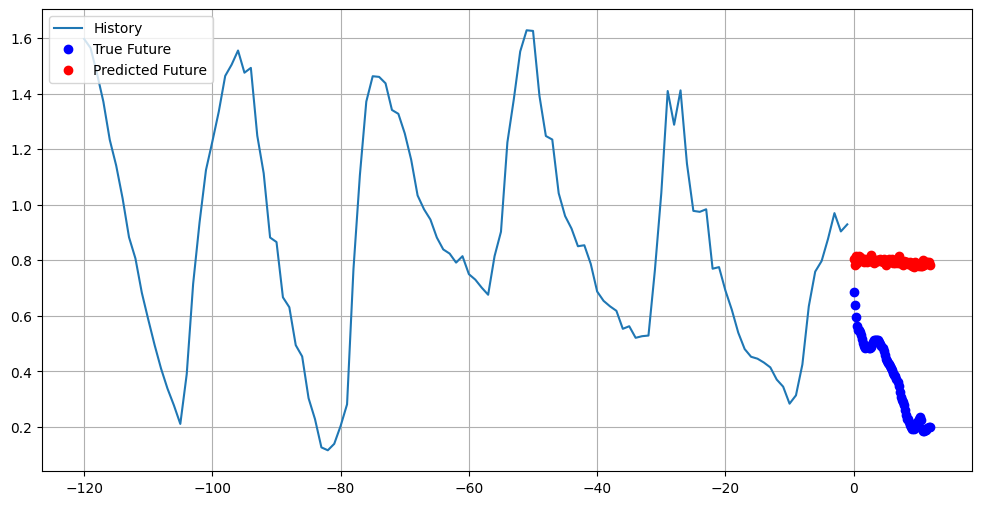

In [32]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], transformer_model.predict(x)[0])